In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import itertools

## Data Exploration notebook shows 54309 Monthly factors!!

In [7]:
monthly_crude = pd.read_csv('./monthly_crude_data.csv',index_col='index',parse_dates=True,infer_datetime_format=True)
monthly_crude.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1170 entries, 1920-01-31 to 2017-06-30
Columns: 54309 entries, PET.EMM_EPMM_PTE_SFL_DPG.M to PET.MBAEXUS2.M
dtypes: float64(54309)
memory usage: 484.8 MB


### Lets look at the Monthly Data

In [33]:
monthly_crude.count().head(15)

PET.EMM_EPMM_PTE_SFL_DPG.M    169
PET.EMM_EPMR_PTE_SWA_DPG.M    169
PET.EMM_EPMR_PTE_SOH_DPG.M    169
PET.EMM_EPMM_PTE_R40_DPG.M    271
PET.EMM_EPMM_PTE_R50_DPG.M    271
PET.EMM_EPM0_PTE_STX_DPG.M    205
PET.EMM_EPMR_PTE_SNY_DPG.M    205
PET.EMM_EPMM_PTE_SWA_DPG.M    169
PET.EMM_EPMP_PTE_NUS_DPG.M    271
PET.EMM_EPMP_PTE_R10_DPG.M    271
PET.EMM_EPMP_PTE_R1X_DPG.M    271
PET.EMM_EPMP_PTE_R1Y_DPG.M    271
PET.EMM_EPMP_PTE_R1Z_DPG.M    271
PET.EMM_EPMP_PTE_R20_DPG.M    271
PET.EMM_EPMP_PTE_R30_DPG.M    271
dtype: int64

### Let's make sure that the Price data is available

In [34]:
df = monthly_crude[['PET.RCLC1.M','PET.RCLC2.M','PET.RCLC3.M','PET.RCLC4.M','PET.RWTC.M']]
df.tail()

,PET.RCLC1.M,PET.RCLC2.M,PET.RCLC3.M,PET.RCLC4.M,PET.RWTC.M
index,,,,,
2017-02-28,53.46,53.93,54.32,54.64,53.47
2017-03-31,49.67,50.22,50.61,50.91,49.33
2017-04-30,51.12,51.52,51.84,52.09,51.06
2017-05-31,48.54,48.86,49.12,49.34,48.48
2017-06-30,NaN,NaN,NaN,NaN,NaN


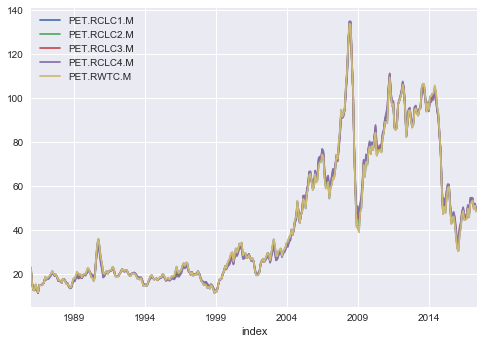

In [35]:
df.plot()
plt.show()

### Spot Price starts January 1986

In [36]:
print ('Spot Price has '+ str(df['PET.RWTC.M'].count())+' months of Data')

#find date where data starts
monthly_crude['PET.RWTC.M'][-df['PET.RWTC.M'].count():].head()

Spot Price has 377 months of Data


index
1986-02-28    15.46
1986-03-31    12.61
1986-04-30    12.84
1986-05-31    15.38
1986-06-30    13.43
Name: PET.RWTC.M, dtype: float64

### 'PET.RWTC.M' Will be the value we are trying to predict

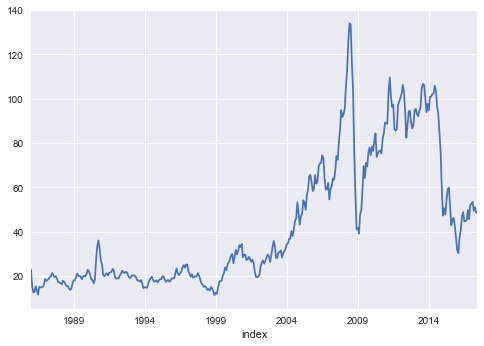

In [37]:
monthly_crude['PET.RWTC.M'].plot()

## Prepare dateset for Dimensionality Reduction

In [38]:
# Set all data series to start January 1986
monthly_crude = monthly_crude.loc['1986-01-31':]

# Remove columns that are missing more than 10% of values
monthly_dataset = monthly_crude[monthly_crude.columns[monthly_crude.count() >= (.90 * monthly_crude['PET.RWTC.M'].count())]]


#fill in values instead of NaN's
monthly_dataset.fillna(method='ffill',axis=0,inplace=True)
monthly_dataset.fillna(0,inplace=True)

# Drop price Data
monthly_dataset = monthly_dataset.drop(['PET.RCLC1.M','PET.RCLC2.M','PET.RCLC3.M','PET.RCLC4.M','PET.RWTC.M'],axis=1)

monthly_dataset.tail(10)

/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/pandas/core/frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,PET.C130013451.M,PET.C130013511.M,PET.C140020001.M,PET.C300011251.M,PET.C400000001.M,PET.C400010001.M,PET.C400011001.M,PET.C400012001.M,PET.C100050021.M,PET.C100050041.M,...,PET.E_ERTRRG_XR0_NUS_C.M,PET.MMSIMP21.M,PET.METIMUS1.M,PET.METIMUS2.M,PET.MMSIMP22.M,PET.MPCEX_NUS-Z00_1.M,PET.MPCEX_NUS-Z00_2.M,PET.MNFEXUS2.M,PET.MPFEXP31.M,PET.MPFEXP32.M
index,,,,,,,,,,,,,,,,,,,,,
2016-09-30,629.9,1135.5,1705.3,27.0,448.2,134.5,20.0,31.2,765.5,8304.3,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2016-10-31,661.0,1196.9,1660.5,27.0,405.1,114.9,15.1,25.3,701.5,8409.6,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2016-11-30,633.1,1175.2,1642.0,27.0,423.7,141.4,14.8,25.3,668.5,8278.1,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2016-12-31,619.0,1125.5,1637.8,153.6,427.1,103.3,10.1,18.0,708.5,8267.1,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2017-01-31,549.4,1009.1,1435.8,153.6,281.4,100.6,8.1,15.4,664.9,7778.7,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2017-02-28,584.4,1081.7,1466.9,153.6,339.4,120.3,11.3,18.8,664.0,8358.3,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2017-03-31,636.7,1130.1,1513.6,153.6,396.9,126.7,9.0,15.0,701.2,8845.7,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2017-04-30,659.6,1164.0,1539.1,153.6,403.8,128.5,10.9,25.2,679.4,8873.0,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0
2017-05-31,659.6,1164.0,1539.1,153.6,403.8,128.5,10.9,25.2,679.4,8873.0,...,86.0,1.0,43.0,1.0,0.0,634.0,20.0,20.0,450.0,15.0


# Removed Thousands of features just by filtering!

In [39]:
monthly_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 1986-01-31 to 2017-06-30
Columns: 3864 entries, PET.C130013451.M to PET.MPFEXP32.M
dtypes: float64(3864)
memory usage: 11.1 MB


In [40]:
y = monthly_crude['PET.RWTC.M'].fillna(method='ffill').values

print(y.dtype)
print(np.shape(y))
# y

float64
(378,)


# Dimensionality Reduction

## Recursive Feature Elimination (RFE)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [42]:
#use linear regression as the model
lr_rfe = LinearRegression()
# rank all features, i.e continue the elimination until the last one
# rfe = RFE(lr_rfe,step=20, n_features_to_select=20)
# rfe.fit(monthly_dataset,y)

# with open('RFE_linearregression.pickle','wb') as f:
#     pickle.dump(rfe, f)
    
pickle_in = open('RFE_linearregression.pickle','rb')
rfe = pickle.load(pickle_in)

In [43]:
# print ("Features sorted by their rank:")
tuple_list_rfe = (sorted(zip(map(lambda x: round(x, 2), rfe.ranking_), monthly_dataset.columns)))
# print (tuple_list_rfe)
name_list_rfe = [x[1] for x in tuple_list_rfe if x[0] == 1]
name_list_rfe

['PET.C100020401.M',
 'PET.C100030281.M',
 'PET.C120020401.M',
 'PET.C120030281.M',
 'PET.EER_EPD2F_PE1_Y35NY_DPG.M',
 'PET.EER_EPD2F_PE3_Y35NY_DPG.M',
 'PET.EER_EPD2F_PF4_Y35NY_DPG.M',
 'PET.EER_EPMRU_PF4_RGC_DPG.M',
 'PET.EER_EPMRU_PF4_Y35NY_DPG.M',
 'PET.MAPEXP11.M',
 'PET.MAPEXP21.M',
 'PET.MAPEXUS1.M',
 'PET.MBCRI2B1.M',
 'PET.MBCRIAP1.M',
 'PET.MBCRIEC1.M',
 'PET.MBCRIP11.M',
 'PET.MPEMTP2P11.M',
 'PET.MTTMXP5P41.M',
 'PET.MUOMTP3P21.M',
 'PET.RBRTE.M']

In [44]:
results_rfe = monthly_dataset[name_list_rfe]
results_rfe.tail()

,PET.C100020401.M,PET.C100030281.M,PET.C120020401.M,PET.C120030281.M,PET.EER_EPD2F_PE1_Y35NY_DPG.M,PET.EER_EPD2F_PE3_Y35NY_DPG.M,PET.EER_EPD2F_PF4_Y35NY_DPG.M,PET.EER_EPMRU_PF4_RGC_DPG.M,PET.EER_EPMRU_PF4_Y35NY_DPG.M,PET.MAPEXP11.M,PET.MAPEXP21.M,PET.MAPEXUS1.M,PET.MBCRI2B1.M,PET.MBCRIAP1.M,PET.MBCRIEC1.M,PET.MBCRIP11.M,PET.MPEMTP2P11.M,PET.MTTMXP5P41.M,PET.MUOMTP3P21.M,PET.RBRTE.M
index,,,,,,,,,,,,,,,,,,,,
2017-02-28,5854.3,4643.3,5365.3,4261.0,1.641,1.660,1.562,1.543,1.547,89.0,30.0,494.0,898.0,4746.0,57435.0,62181.0,62.0,1966.0,460.0,54.87
2017-03-31,5495.1,5076.7,4967.1,4591.3,1.536,1.551,1.492,1.523,1.492,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,51.59
2017-04-30,5746.0,5214.1,5194.3,4705.0,1.590,1.604,1.523,1.621,1.611,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,52.31
2017-05-31,5746.0,5214.1,5194.3,4705.0,1.514,1.527,1.454,1.519,1.540,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,50.33
2017-06-30,5746.0,5214.1,5194.3,4705.0,1.514,1.527,1.454,1.519,1.540,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,50.33


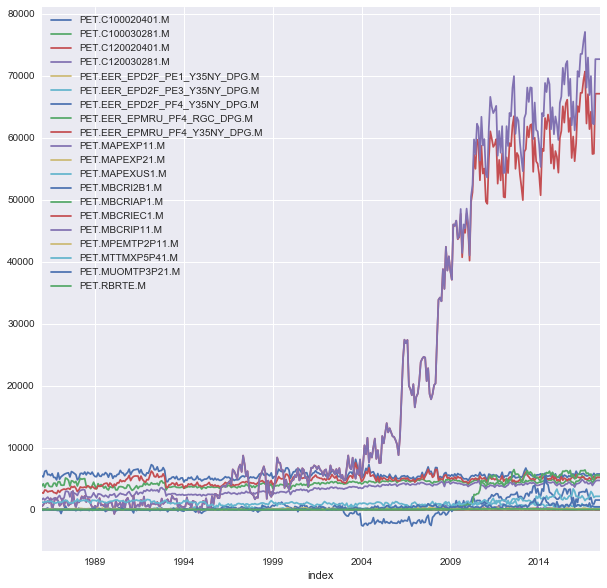

In [45]:
results_rfe.plot(figsize=(10,10))

## Recursive Feature Elimination Cross Validation (RFECV)

In [46]:
from sklearn.feature_selection import RFECV

In [47]:
#use linear regression as the model
lr_rfecv = LinearRegression()
# rfecv = RFECV(lr_rfecv,step=50)
# rfecv.fit(monthly_dataset,y)

# with open('RFECV_linearregression.pickle','wb') as f:
#     pickle.dump(rfecv, f)
    
pickle_in = open('RFECV_linearregression.pickle','rb')
rfecv = pickle.load(pickle_in)

In [51]:
# print ("Features sorted by their rank:")
tuple_list_rfecv = (sorted(zip(map(lambda x: round(x, 2), rfecv.ranking_), monthly_dataset.columns)))
# print (tuple_list_rfecv)
name_list_rfecv = [x[1] for x in tuple_list_rfecv if x[0] == 1]
name_list_rfecv

['PET.EER_EPD2F_PE1_Y35NY_DPG.M',
 'PET.EER_EPD2F_PE3_Y35NY_DPG.M',
 'PET.EER_EPD2F_PF4_Y35NY_DPG.M',
 'PET.EER_EPMRU_PF4_RGC_DPG.M',
 'PET.EER_EPMRU_PF4_Y35NY_DPG.M',
 'PET.MBCMRP51.M',
 'PET.MBCMXP5P31.M',
 'PET.MBCRI2A1.M',
 'PET.MBCRI2B1.M',
 'PET.MBCRI2C1.M',
 'PET.MBCRIP21.M',
 'PET.MCRIMUSMX2.M',
 'PET.MTTIMUSMX2.M',
 'PET.RBRTE.M']

In [52]:
results_rfecv = monthly_dataset[name_list_rfecv]
results_rfecv.tail()

,PET.EER_EPD2F_PE1_Y35NY_DPG.M,PET.EER_EPD2F_PE3_Y35NY_DPG.M,PET.EER_EPD2F_PF4_Y35NY_DPG.M,PET.EER_EPMRU_PF4_RGC_DPG.M,PET.EER_EPMRU_PF4_Y35NY_DPG.M,PET.MBCMRP51.M,PET.MBCMXP5P31.M,PET.MBCRI2A1.M,PET.MBCRI2B1.M,PET.MBCRI2C1.M,PET.MBCRIP21.M,PET.MCRIMUSMX2.M,PET.MTTIMUSMX2.M,PET.RBRTE.M
index,,,,,,,,,,,,,,
2017-02-28,1.641,1.660,1.562,1.543,1.547,4606.0,3515.0,3550.0,898.0,-308.0,4140.0,516.0,607.0,54.87
2017-03-31,1.536,1.551,1.492,1.523,1.492,4644.0,3426.0,5192.0,1541.0,306.0,7039.0,550.0,630.0,51.59
2017-04-30,1.590,1.604,1.523,1.621,1.611,4644.0,3426.0,5192.0,1541.0,306.0,7039.0,550.0,630.0,52.31
2017-05-31,1.514,1.527,1.454,1.519,1.540,4644.0,3426.0,5192.0,1541.0,306.0,7039.0,550.0,630.0,50.33
2017-06-30,1.514,1.527,1.454,1.519,1.540,4644.0,3426.0,5192.0,1541.0,306.0,7039.0,550.0,630.0,50.33


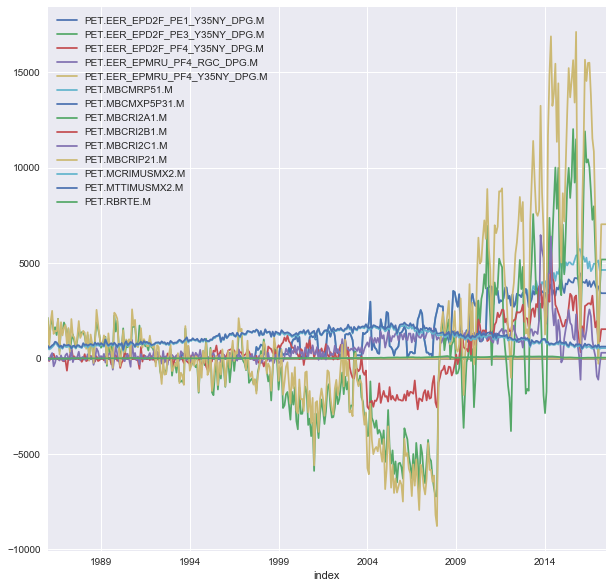

In [54]:
results_rfecv.plot(figsize=(10,10))

### Lets find out what these factors are...

In [55]:
data = pd.read_json('./PET.txt',orient='columns',lines=True,convert_dates=['start','end'])
series_data = data[pd.notnull(data['series_id'])]
series_data = (series_data[['series_id','name','units','description','unitsshort','f','start','end','last_updated']]
 .set_index('series_id')
)
series_data['start']= pd.to_datetime(series_data['start'])
series_data['end']= pd.to_datetime(series_data['end'])

### Pass through list of factors to obtain the description of the factors

In [56]:
series_data.loc[name_list_rfe]

,name,units,description,unitsshort,f,start,end,last_updated
series_id,,,,,,,,
PET.C100020401.M,Oklahoma Total Gasoline All Sales/Deliveries b...,Thousand Gallons per Day,Oklahoma Total Gasoline All Sales/Deliveries b...,Mgal/d,M,1970-01-03 07:05:01,1970-01-03 08:01:42,2017-04-21T11:42:10-04:00
PET.C100030281.M,Mississippi Total Gasoline All Sales/Deliverie...,Thousand Gallons per Day,Mississippi Total Gasoline All Sales/Deliverie...,Mgal/d,M,1970-01-03 07:05:01,1970-01-03 08:01:42,2017-04-21T11:42:10-04:00
PET.C120020401.M,Oklahoma Regular Gasoline All Sales/Deliveries...,Thousand Gallons per Day,Oklahoma Regular Gasoline All Sales/Deliveries...,Mgal/d,M,1970-01-03 07:05:01,1970-01-03 08:01:42,2017-04-21T11:42:10-04:00
PET.C120030281.M,Mississippi Regular Gasoline All Sales/Deliver...,Thousand Gallons per Day,Mississippi Regular Gasoline All Sales/Deliver...,Mgal/d,M,1970-01-03 07:05:01,1970-01-03 08:01:42,2017-04-21T11:42:10-04:00
PET.EER_EPD2F_PE1_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Future Contr...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Future Contr...,$/gal,M,1970-01-03 07:00:01,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPD2F_PE3_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Future Contr...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Future Contr...,$/gal,M,1970-01-03 07:00:01,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPD2F_PF4_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Spot Price F...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Spot Price FOB,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPMRU_PF4_RGC_DPG.M,U.S. Gulf Coast Conventional Gasoline Regular ...,Dollars per Gallon,U.S. Gulf Coast Conventional Gasoline Regular ...,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPMRU_PF4_Y35NY_DPG.M,New York Harbor Conventional Gasoline Regular ...,Dollars per Gallon,New York Harbor Conventional Gasoline Regular ...,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00


In [27]:
series_data.loc[name_list_rfecv]

,name,units,description,unitsshort,f,start,end,last_updated
series_id,,,,,,,,
PET.EER_EPD2F_PE1_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Future Contr...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Future Contr...,$/gal,M,1970-01-03 07:00:01,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPD2F_PE3_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Future Contr...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Future Contr...,$/gal,M,1970-01-03 07:00:01,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPD2F_PF4_Y35NY_DPG.M,New York Harbor No. 2 Heating Oil Spot Price F...,Dollars per Gallon,New York Harbor No. 2 Heating Oil Spot Price FOB,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPMRU_PF4_RGC_DPG.M,U.S. Gulf Coast Conventional Gasoline Regular ...,Dollars per Gallon,U.S. Gulf Coast Conventional Gasoline Regular ...,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.EER_EPMRU_PF4_Y35NY_DPG.M,New York Harbor Conventional Gasoline Regular ...,Dollars per Gallon,New York Harbor Conventional Gasoline Regular ...,$/gal,M,1970-01-03 07:10:06,1970-01-03 08:01:44,2017-05-10T13:24:45-04:00
PET.MBCMRP51.M,"West Coast (PADD 5) Receipts by Pipeline, Tank...",Thousand Barrels,"West Coast (PADD 5) Receipts by Pipeline, Tank...",MBBL,M,1970-01-03 07:10:01,1970-01-03 08:01:42,2017-05-02T14:54:09-04:00
PET.MBCMXP5P31.M,"West Coast (PADD 5) Receipts by Pipeline, Tank...",Thousand Barrels,"West Coast (PADD 5) Receipts by Pipeline, Tank...",MBBL,M,1970-01-03 07:10:01,1970-01-03 08:01:42,2017-05-02T14:54:09-04:00
PET.MBCRI2A1.M,Refining District Indiana-Illinois-Kentucky Re...,Thousand Barrels,Refining District Indiana-Illinois-Kentucky Re...,Mbbl,M,1970-01-03 07:10:01,1970-01-03 08:01:42,2017-05-02T14:54:09-04:00
PET.MBCRI2B1.M,Refining District Minnesota-Wisconsin-North Da...,Thousand Barrels,Refining District Minnesota-Wisconsin-North Da...,Mbbl,M,1970-01-03 07:10:01,1970-01-03 08:01:42,2017-05-02T14:54:09-04:00


In [57]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, preprocessing 
# results_rfe = preprocessing.scale(results_rfe)
results_rfe.tail()

,PET.C100020401.M,PET.C100030281.M,PET.C120020401.M,PET.C120030281.M,PET.EER_EPD2F_PE1_Y35NY_DPG.M,PET.EER_EPD2F_PE3_Y35NY_DPG.M,PET.EER_EPD2F_PF4_Y35NY_DPG.M,PET.EER_EPMRU_PF4_RGC_DPG.M,PET.EER_EPMRU_PF4_Y35NY_DPG.M,PET.MAPEXP11.M,PET.MAPEXP21.M,PET.MAPEXUS1.M,PET.MBCRI2B1.M,PET.MBCRIAP1.M,PET.MBCRIEC1.M,PET.MBCRIP11.M,PET.MPEMTP2P11.M,PET.MTTMXP5P41.M,PET.MUOMTP3P21.M,PET.RBRTE.M
index,,,,,,,,,,,,,,,,,,,,
2017-02-28,5854.3,4643.3,5365.3,4261.0,1.641,1.660,1.562,1.543,1.547,89.0,30.0,494.0,898.0,4746.0,57435.0,62181.0,62.0,1966.0,460.0,54.87
2017-03-31,5495.1,5076.7,4967.1,4591.3,1.536,1.551,1.492,1.523,1.492,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,51.59
2017-04-30,5746.0,5214.1,5194.3,4705.0,1.590,1.604,1.523,1.621,1.611,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,52.31
2017-05-31,5746.0,5214.1,5194.3,4705.0,1.514,1.527,1.454,1.519,1.540,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,50.33
2017-06-30,5746.0,5214.1,5194.3,4705.0,1.514,1.527,1.454,1.519,1.540,106.0,84.0,358.0,1541.0,5574.0,67103.0,72677.0,110.0,2143.0,452.0,50.33


In [58]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(results_rfe, y, test_size=0.2)
lr_rfe.fit(X_train,y_train)

lr_rfe.score(X_test,y_test)

0.98876904327119952

In [61]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

def difference(dataset):
    # create a differenced series
#     return dataset
    diff = list()
    for i in range(len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return diff

def predict_ARIMA(series,num_months=False):    
    # fit model
    model = smt.ARIMA(series, order=(1,0,1))
    model_fit = model.fit(disp=-1)
#     return model_fit
    
    # multi-step out-of-sample forecast
    predict = model_fit.predict(start=results_rfe.iloc[-1].name, 
                                end=results_rfe.iloc[-1].name+relativedelta(months=num_months))
    return predict

/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [62]:
results_rfe['PET.C100020401.M'].tail()

index
2017-02-28    5854.3
2017-03-31    5495.1
2017-04-30    5746.0
2017-05-31    5746.0
2017-06-30    5746.0
Name: PET.C100020401.M, dtype: float64

In [63]:
predict_ARIMA(results_rfe['PET.C100020401.M'],num_months=5)

2017-06-30    5693.747694
2017-07-31    5697.716505
2017-08-31    5670.228678
2017-09-30    5649.063271
2017-10-31    5632.766079
2017-11-30    5620.217372
Freq: M, dtype: float64

In [38]:
def curve_fit(series):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#     warnings.filterwarnings("ignore") # specify to ignore warning messages
    param_list=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:        
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                param_list.append([results.aic,(param,param_seasonal)])
    #             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return param_list

In [39]:
def predict_SARIMAX(series,num_months=False):
    #return optimized paramaters
    value = curve_fit(series)
    value.sort()
    value
    
    #pass optimized paramater to ARIMA
    mod = sm.tsa.statespace.SARIMAX(series,
                                    order=value[0][1][0],
                                    seasonal_order=value[0][1][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    #print(series)
    #print(results.summary().tables[1])
    
    #predict number of months out of sample data
    pred = results.predict(start=results_rfe.iloc[-1].name, 
                                    end=results_rfe.iloc[-1].name+relativedelta(months=num_months))
    return pred

In [40]:
#new dataframe for forcasted values
forecast =pd.DataFrame()

#for each column in the dataframe pass through column to ARIMA
all_cols = results_rfe.columns
for col in all_cols:
    # call function for ARIMA here and assign this to a new series
#     forecast[col] = forecast_ARIMA(results_rfe[col],5)
    forecast[col] = predict_SARIMAX(results_rfe[col],5)
    
forecast.to_csv('forecast.csv')    

/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Prometheus/Code/Chipy_Mentorship/venv3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Prometheus/Code/Chipy_Mentorship/

In [42]:
forecast 

,PET.C100020401.M,PET.C100030281.M,PET.C120020401.M,PET.C120030281.M,PET.EER_EPD2F_PE1_Y35NY_DPG.M,PET.EER_EPD2F_PE3_Y35NY_DPG.M,PET.EER_EPD2F_PF4_Y35NY_DPG.M,PET.EER_EPMRU_PF4_RGC_DPG.M,PET.EER_EPMRU_PF4_Y35NY_DPG.M,PET.MAPEXP11.M,PET.MAPEXP21.M,PET.MAPEXUS1.M,PET.MBCRI2B1.M,PET.MBCRIAP1.M,PET.MBCRIEC1.M,PET.MBCRIP11.M,PET.MPEMTP2P11.M,PET.MTTMXP5P41.M,PET.MUOMTP3P21.M,PET.RBRTE.M
2017-06-30,5890.865124,5301.409809,5321.678974,4774.269053,1.490431,1.497725,1.433713,1.482687,1.498119,66.312056,178.724189,569.736628,1637.287974,5589.819163,66843.652531,72554.294666,108.689378,2303.327926,548.183712,49.446850
2017-07-31,5553.488049,5158.627631,5012.344295,4650.170890,1.514000,1.527000,1.454000,1.518131,1.545534,112.817657,168.801091,498.120038,1622.637117,5734.410245,69310.447328,75086.486196,98.888730,2000.356448,574.220591,50.900776
2017-08-31,5664.631864,5115.721876,5124.599226,4649.745606,1.514000,1.527000,1.454000,1.508876,1.537670,122.506303,187.006444,592.282918,1385.712450,5814.895819,69964.317127,75826.159125,110.471786,1924.385884,593.067660,50.929118
2017-09-30,5610.167845,5019.991918,5140.943956,4590.451244,1.514000,1.527000,1.454000,1.499678,1.529846,131.574308,167.379762,583.715725,1710.280233,5280.930182,63041.950195,68336.299816,104.815635,2096.994645,582.553058,50.536516
2017-10-31,5603.478772,4986.363739,5116.909493,4552.594836,1.514000,1.527000,1.454000,1.490535,1.522062,162.844636,151.901849,584.424109,1504.417620,5650.482140,66790.657296,72424.905915,98.266153,2126.780851,661.785220,49.725996
2017-11-30,5525.561020,4934.699350,5045.264594,4504.756093,1.514000,1.527000,1.454000,1.481448,1.514318,110.134924,84.326105,436.726579,817.450324,5092.583532,62207.677299,67274.092316,117.327074,2314.180233,679.350526,48.361090


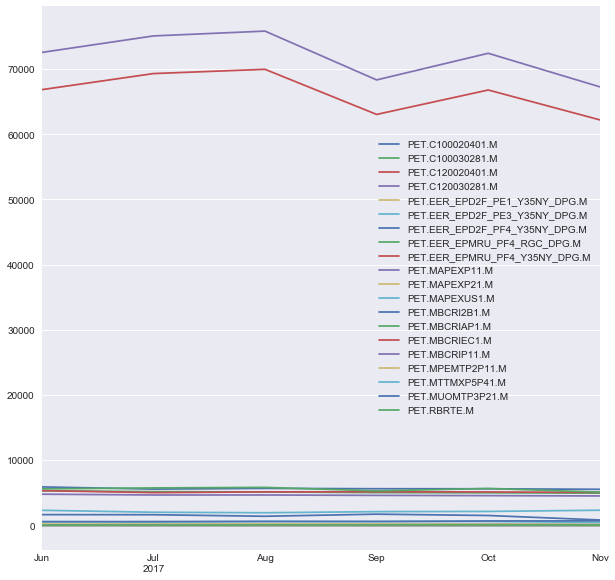

In [43]:
forecast.plot(figsize=(10,10))
plt.show()

In [44]:
lr_rfe.predict(forecast)

array([ 58.4846988 ,  51.50194021,  51.69383371,  48.76481632,
        45.35473235,  44.85182141])

# lr_rfe fit model to predict price from forcasted features

In [45]:
forecast['Prediction'] = lr_rfe.predict(forecast)
forecast['Prediction']

2017-06-30    58.484699
2017-07-31    51.501940
2017-08-31    51.693834
2017-09-30    48.764816
2017-10-31    45.354732
2017-11-30    44.851821
Freq: M, Name: Prediction, dtype: float64